# Classification model with Keras: LSE vowels

**Source:** [Image classification from scratch](https://www.tensorflow.org/tutorials/keras/classification)<br>
**Author:** Vanessa Alvear <br>
**Date created:** 2023/03/30<br>
**Last modified:** 2023/04/27<br>
**Description:** Training an image classifier from scratch on the vowels from the Spanish Sign Language (Lengua de Signos Española - LSE).

## Introduction

This guide trains a neural network model to classify images of the vowels of the Spanish Sign Lenguage (Lengua de Signos Española - LSE) using the [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

This notebook shows how to do image classification from scratch of the vowels of the LSE, 
starting from JPG image files load it from the dataset vowelsLSE. This code is based on the workflow on Basic classification: Classify images of clothing of Tensorflow documentation. 

In the next figure, we can see signs of the vowels from LSE.

In [1]:
from PIL import Image

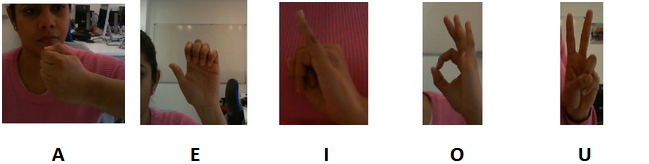

In [2]:
Image.open("vowels_lse_dataset_sample.png")

## Libraries

We define the GPU to be used and import the libraries

In [3]:
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [4]:
import tensorflow as tf

2023-04-28 09:23:28.811991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 09:23:28.941232: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print(tf.__version__)

2.10.0


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import the modules
import os
import shutil
from imutils import paths

# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder

In [8]:
#from PIL import Image
import cv2

In [9]:
from tensorflow import keras
# import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers, losses
import keras_tuner as kt

In [10]:
seed = 1234

## Dataset: vowelsLSE

It was created on March, 2023 in the Universidad de La Rioja. It consists of RGB images of 5 different gestures in JPG format. It contains three folders, one for training `train` (4376 images), one for testing `test` (1215 images), one for validation (487 images) for a total of 6078 images. It contains 5 classes. The images can be classified into: 
  - A (600 (right hand) 615 (left hand), total images: 1215)
  - E (600 (right hand) 619 (left hand), total images: 1219)
  - I (601 (right hand) 611 (left hand), total images: 1212)
  - O (601 (right hand) 619 (left hand), total images: 1220)
  - U (612 (right hand) 600 (left hand), total images: 1212)
  
The images are 300 x 300 in size and have a white background so that they are the same size.

The data is loaded as a folder with .zip extension. Unzip the data

In [11]:
#!unzip train_data_with_subfolders.zip

In [12]:
#!unzip valid_data_with_subfolders.zip

In [13]:
#!unzip test_data_with_subfolders.zip

Now we have three folders `train, test, valid` which contains five subfolders, `A, E, I, O`,  and `U`. Each subfolder has image files for each category. 

In [14]:
!ls train

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


In [15]:
!ls valid

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


In [16]:
!ls test

/bin/bash: /opt/anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
A  E  I  O  U


Let's name a variable for the class name

In [17]:
class_names = ['A', 'E', 'I', 'O', 'U']

We define the path for train, valid, and test

In [18]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

We can count the number of images for each subfolder

In [19]:
def countFilesPath(path, classNames, path_name):
    for i in classNames:
        print("Number of files "+ path_name + str(i) +" =", len([entry for entry in os.listdir(path+'/'+ str(i)) if os.path.isfile(os.path.join(path+'/'+ str(i), entry))]))

In [20]:
countFilesPath(train_path, class_names, "train_path_")

Number of files train_path_A = 875
Number of files train_path_E = 877
Number of files train_path_I = 873
Number of files train_path_O = 878
Number of files train_path_U = 873


In [21]:
countFilesPath(valid_path, class_names, "valid_path_")

Number of files valid_path_A = 97
Number of files valid_path_E = 98
Number of files valid_path_I = 97
Number of files valid_path_O = 98
Number of files valid_path_U = 97


In [22]:
countFilesPath(test_path, class_names, "test_path_")

Number of files test_path_A = 243
Number of files test_path_E = 244
Number of files test_path_I = 242
Number of files test_path_O = 244
Number of files test_path_U = 242


Then, the total data:
- Train = 4376
- Valid = 487
- Test = 1215

In [23]:
train_labels = pd.read_csv('train_labels.csv')
valid_labels = pd.read_csv('valid_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

In [24]:
print('train dimension = ', train_labels.shape)
print('valid dimension = ', valid_labels.shape)
print('test dimension = ', test_labels.shape)

train dimension =  (4376, 1)
valid dimension =  (487, 1)
test dimension =  (1215, 1)


In [25]:
train_labels.tail(3)

,label
4373,U
4374,U
4375,U


In [26]:
valid_labels.tail(3)

,label
484,U
485,U
486,U


In [27]:
test_labels.tail(3)

,label
1212,U
1213,U
1214,U


First, we need to merge all the train folders into one `all_train`. This means, merging all data from train folders A, E, I, O, U into one `all_train`. The same idea for the test, and valid data.

In [28]:
!mkdir all_train

In [29]:
!mkdir all_test

In [30]:
!mkdir all_valid

In [31]:
def merge2_OneFolder(list_classNames, path_src, path_dest):
    """
    This function receive three params to copy files from different folders
    from path_src into one folder name path_dest

    Params
    list_classNames: list of names of the folders which corresponds to each class
    path_src: path of the folder which contains the folders of each class
    path_dest: path of the new folder created by the images of every folder
    """
    for i in list_classNames:
        # Image path for path_src
        imagePath = os.path.join(path_src, str(i)+'/')  #Path(path_src + str(i)+'/')
        # List of all image data name in path_src from every folder inside
        imagesList = os.listdir(imagePath)
        # Run in each image from imagesList
    for image in imagesList:
        # Combines path names from imagePath and image in a complete name
        f = os.path.join(imagePath, image)
        # Copy the elements from path_src in path_dest
        shutil.copy(f, path_dest + (image))

We define the paths for the new folders

In [32]:
train_path_dest = 'all_train/'
test_path_dest = 'all_test/'
valid_path_dest = 'all_valid/'

For train data

In [33]:
merge2_OneFolder(class_names, train_path, train_path_dest)

For test data

In [34]:
merge2_OneFolder(class_names, test_path, test_path_dest)

For valid data

In [35]:
merge2_OneFolder(class_names, valid_path, valid_path_dest)

In [36]:
print("Number of files train_path_dest = ", len([entry for entry in os.listdir(train_path_dest) if os.path.isfile(os.path.join(train_path_dest, entry))]))
print("Number of files valid_path_dest = ", len([entry for entry in os.listdir(valid_path_dest) if os.path.isfile(os.path.join(valid_path_dest, entry))]))
print("Number of files test_path_dest = ", len([entry for entry in os.listdir(test_path_dest) if os.path.isfile(os.path.join(test_path_dest, entry))]))

Number of files train_path_dest =  4376
Number of files valid_path_dest =  487
Number of files test_path_dest =  1215


Then, we convert to a tensors, images and labels

In [37]:
# Function to convert every image file from folder all_trainData into arrays and return a list of arrays
def image2array(path):
    """
    This function convert every image file from folder path into arrays 
    and return a list of arrays

    Params
    path: path folder where are the images to convert into arrays
    image_size: of the images in the path
    """
    list1 = []
    # Run each image from path
    for images in os.listdir(path):
        # Load and read each image from folder as an array
        load_img = cv2.imread(path + "/" + images)  
        gray = cv2.cvtColor(load_img, cv2.COLOR_BGR2GRAY)
        # Adding each array into a list array_list
        list1.append(gray)
        array_list = np.array(list1)
    return(array_list)

In [38]:
# Train path 
all_train_path = 'all_train'
# Test path 
all_test_path = 'all_test'
# Test path 
all_valid_path = 'all_valid'

# Image size param
image_size = (300, 300)

In [39]:
print("Number of files train_path_dest = ", len([entry for entry in os.listdir(all_train_path) if os.path.isfile(os.path.join(all_train_path, entry))]))
print("Number of files valid_path_dest = ", len([entry for entry in os.listdir(all_valid_path) if os.path.isfile(os.path.join(all_valid_path, entry))]))
print("Number of files test_path_dest = ", len([entry for entry in os.listdir(all_test_path) if os.path.isfile(os.path.join(all_test_path, entry))]))

Number of files train_path_dest =  4376
Number of files valid_path_dest =  487
Number of files test_path_dest =  1215


In [40]:
array_allTrain = image2array(all_train_path)

In [42]:
array_allTest = image2array(all_test_path)

In [43]:
array_allValid = image2array(all_valid_path)

In [44]:
array_allTrain.shape

(4376, 300, 300)

In [45]:
array_allTest.shape

(1215, 300, 300)

In [46]:
array_allValid.shape

(487, 300, 300)

We convert labels from categorical to numerical data

In [47]:
# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit encoder on the training dataset
le.fit(train_labels['label'])

# Transform both datasets
num_train_label= le.transform(train_labels['label'])
num_test_label= le.transform(test_labels['label'])
num_valid_label = le.transform(valid_labels['label'])

In [48]:
# printing label
print('train labels = ', num_train_label)
print('test labels =', num_test_label)

train labels =  [0 0 0 ... 4 4 4]
test labels = [0 0 0 ... 4 4 4]


In [49]:
# printing label
print('train labels dim = ', num_train_label.shape)
print('test labels dim =', num_test_label.shape)
print('valid labels dim =', num_valid_label.shape)

train labels dim =  (4376,)
test labels dim = (1215,)
valid labels dim = (487,)


At this point, we have:

* The `array_allTrain` and `num_train_label` arrays are the *training set*—the data the model uses to learn.
* The `array_allValid` and `num_valid_label` arrays are the *validation set*—the data the model uses to validate.
* The model is tested against the *test set*, the `array_allTest`, and `num_test_label` arrays.

The images are 300x300 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 4. These corresponds to the *class* of vowels of LSE the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>A</td>
  </tr>
  <tr>
    <td>1</td>
    <td>E</td>
  </tr>
    <tr>
    <td>2</td>
    <td>I</td>
  </tr>
    <tr>
    <td>3</td>
    <td>O</td>
  </tr>
    <tr>
    <td>4</td>
    <td>U</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [50]:
class_names

['A', 'E', 'I', 'O', 'U']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 4376 images in the training set, with each image represented as 300 x 300 pixels:

In [51]:
array_allTrain.shape

(4376, 300, 300)

Likewise, there are 4376 labels in the training set:

In [52]:
len(train_labels)

4376

Each label is an integer between 0 and 4:

In [53]:
num_train_label

array([0, 0, 0, ..., 4, 4, 4])

There are 1215 images in the test set. Again, each image is represented as 300 x 300 pixels:

In [54]:
array_allTest.shape

(1215, 300, 300)

And the test set contains 1215 images labels:

In [55]:
len(num_test_label)

1215

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

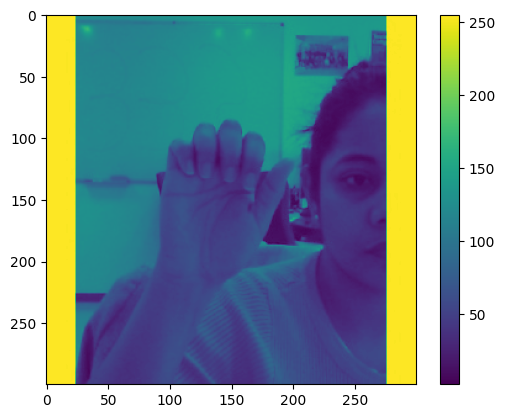

In [56]:
plt.figure()
plt.imshow(array_allTrain[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *train*, *valid*, and the *test sets* be preprocessed in the same way:

In [57]:
train_images = array_allTrain / 255.0
test_images = array_allTest / 255.0
valid_images = array_allValid / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 9 images from the *training set* and display the class name below each image.

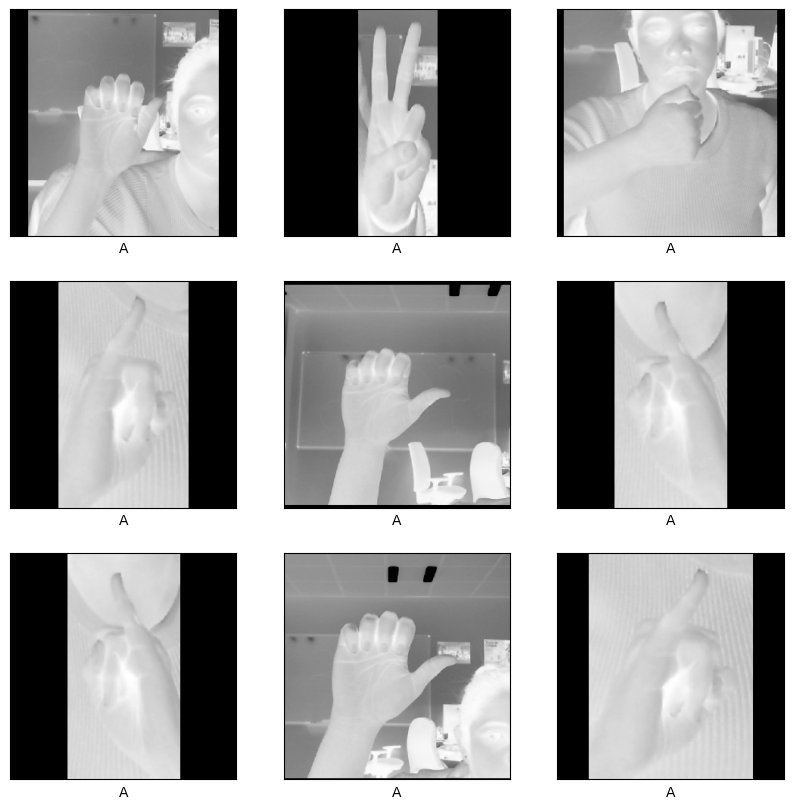

In [58]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[num_train_label[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, 300)),
    tf.keras.layers.Dense(128, activation='softmax'),
    tf.keras.layers.Dense(5)
])

2023-04-28 09:28:47.269086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 09:28:47.730581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5


The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 300 by 300 pixels) to a one-dimensional array (of 300 * 300 = 90000 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 5. Each node contains a score that indicates the current image belongs to one of the 5 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [61]:
model.fit(train_images, num_train_label, epochs=30)

Epoch 1/30
137/137 [==============================] - 2s 7ms/step - loss: 1.6130 - accuracy: 0.1990
Epoch 2/30
137/137 [==============================] - 1s 7ms/step - loss: 1.6103 - accuracy: 0.2006
Epoch 3/30
137/137 [==============================] - 1s 7ms/step - loss: 1.6098 - accuracy: 0.2006
Epoch 4/30
137/137 [==============================] - 1s 8ms/step - loss: 1.6098 - accuracy: 0.1936
Epoch 5/30
137/137 [==============================] - 1s 7ms/step - loss: 1.6098 - accuracy: 0.1865
Epoch 6/30
137/137 [==============================] - 1s 7ms/step - loss: 1.6097 - accuracy: 0.1931
Epoch 7/30
137/137 [==============================] - 1s 8ms/step - loss: 1.6097 - accuracy: 0.1894
Epoch 8/30
137/137 [==============================] - 1s 8ms/step - loss: 1.6097 - accuracy: 0.1926
Epoch 9/30
137/137 [==============================] - 1s 8ms/step - loss: 1.6097 - accuracy: 0.1972
Epoch 10/30
137/137 [==============================] - 1s 8ms/step - loss: 1.6097 - accuracy: 0.1901

In [62]:
model.save('Model_1') 

INFO:tensorflow:Assets written to: Model_1/assets


In [63]:
valid_loss, valid_acc = model.evaluate(valid_images,  num_valid_label, verbose=2)

print('\nValid accuracy:', valid_acc)

16/16 - 0s - loss: 1.6094 - accuracy: 0.1992 - 172ms/epoch - 11ms/step

Valid accuracy: 0.19917865097522736


### Evaluate accuracy

Next, compare how the model performs on the test dataset:

For the first model

In [80]:
test_loss, test_acc = model.evaluate(test_images,  num_test_label, verbose=2)

print('\nTest accuracy:', test_acc)

38/38 - 0s - loss: 1.6094 - accuracy: 0.2000 - 232ms/epoch - 6ms/step

Test accuracy: 0.20000000298023224


Then we find a better performance than the validation set.

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret. 

In [65]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [66]:
predictions = probability_model.predict(test_images)

38/38 [==============================] - 0s 5ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [67]:
predictions[0]

array([0.20084503, 0.2003918 , 0.19953835, 0.20014268, 0.19908215],
      dtype=float32)

A prediction is an array of 5 numbers. They represent the model's "confidence" that the image corresponds to each of the 5 different vowels. You can see which label has the highest confidence value:

In [68]:
np.argmax(predictions[0])

0

So, the model is most confident that this image is the vowel A, or `class_names[0]`. Examining the test label shows that this classification is correct:

In [69]:
num_test_label[0]

0

Then, the prediction was correct. 

Graph this to look at the full set of 5 class predictions.

In [70]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                            100*np.max(predictions_array),
                            class_names[true_label]),
                            color=color)    

In [71]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. **Correct prediction labels are blue and incorrect prediction labels are red**. The number gives the percentage (out of 100) for the predicted label.

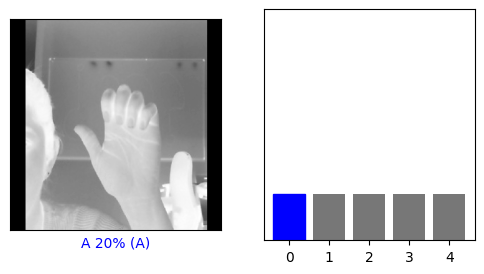

In [72]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], num_test_label, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  num_test_label)
plt.show()

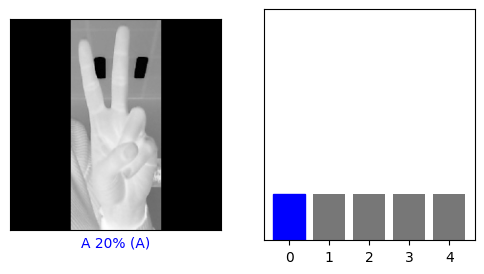

In [73]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], num_test_label, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  num_test_label)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

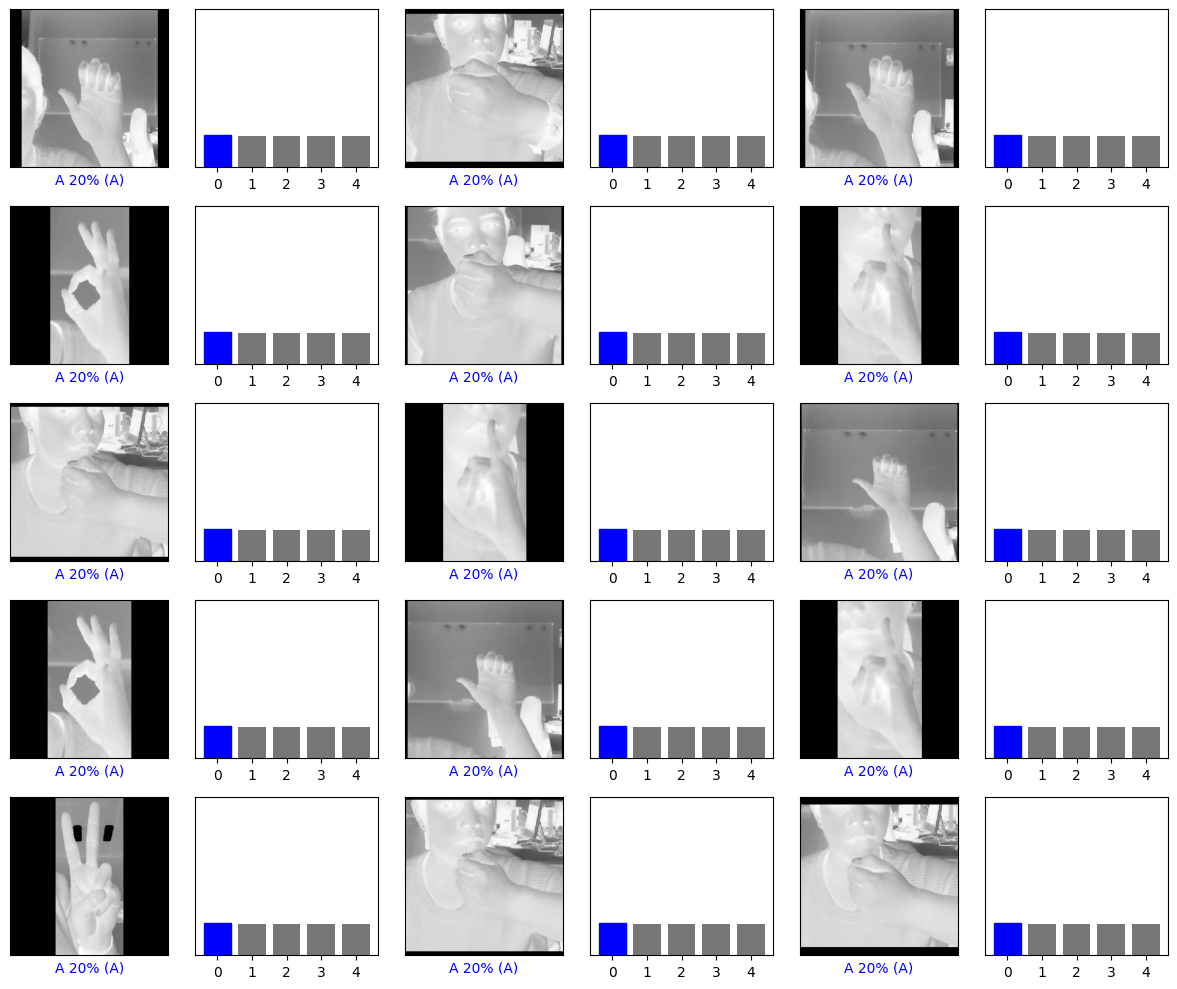

In [74]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], num_test_label, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], num_test_label)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [75]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(300, 300)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [76]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 300, 300)


Now predict the correct label for this image:

In [77]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 14ms/step
[[0.20084503 0.2003918  0.19953835 0.20014268 0.19908215]]


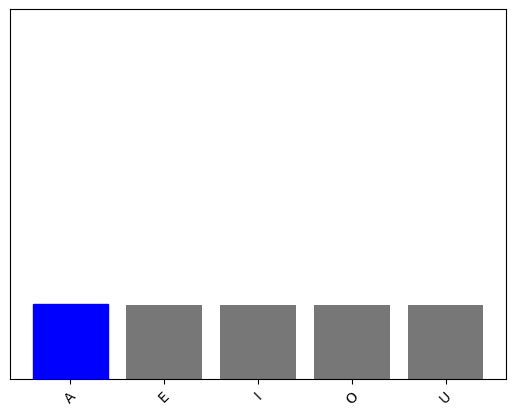

In [78]:
plot_value_array(1, predictions_single[0], num_test_label)
_ = plt.xticks(range(5), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [79]:
np.argmax(predictions_single[0])

0

And the model predicts a label as expected.